In [21]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
!ls "/content/drive/My Drive/EC523Project"
#!ls "/content/drive/Shared with me/EC523Project"

 523_Project_Status_Update_Template.docx
 Augmented_data
 Augmented_data_original+3transforms
 AutoLiverCancerDetection.ipynb
 copy_transUnet.ipynb
'EC523 Project Final Report.gdoc'
'EC 523 Project.gdoc'
'EC 523 Project Proposal.gdoc'
 Figures.gdoc
'Group 5- 523 Deep Learning Project Presentation.gslides'
 Kvasir-SEG
 lits_df.csv
 lits_probe.csv
 lits_test.csv
 lits_train.csv
 Liver_Tumor
'Loss Func AutoLiverCancerDetection.ipynb'
'Resize_augmented(512x512x512)'
 SegmentationData
 TransUnet2.ipynb
 transUnet.ipynb
 transunet_model1_2.pth
 transunet_model1_state.pth
 unet_aspp_classweight124_30_dce3+ce7.pth
 unet_aspp_softmax_classweight123_20_dce+ce+boundary.pth
 unet_aspp_softmax_classweight123.pth
 unet_aspp_softmax_weight123_20_new.pth
'UNet++ AutoLiverCancerDetection.ipynb'
 VolumeData


# Training and Test Datasets

**Load the Data**

In [3]:
# Install necessary libraries. run only once
!pip install torchio==0.18.90 --quiet
!pip install pandas --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install scikit-image --quiet
!curl -s -o colormap.txt https://raw.githubusercontent.com/thenineteen/Semiology-Visualisation-Tool/master/slicer/Resources/Color/BrainAnatomyLabelsV3_0.txt
!curl -s -o slice_7t.jpg https://www.statnews.com/wp-content/uploads/2019/08/x961_unsmoothed_cropped-copy-768x553.jpg
!curl -s -o slice_histo.jpg https://upload.wikimedia.org/wikipedia/commons/6/64/Medulloepithelioma_Histology.jpg
!curl -s -o vhp.zip https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Sample-Data/Six%20slices%20from%20the%20Visible%20Male.zip
!unzip -o vhp.zip > /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.7/172.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.6 MB/s eta 0:00:00


In [4]:
import torch
import torchio as tio
from torchio import AFFINE, DATA, PATH, TYPE, STEM


In [19]:
import pickle

# Specify the file path
file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset2.pkl'
# Open the file in read-binary mode and load the dataset
with open(file_path, 'rb') as file:
    augmented_dataset = pickle.load(file)


In [ ]:
print(len(augmented_dataset))

In [ ]:
import matplotlib.pyplot as plt

subject = augmented_dataset[1]
print(type(subject))

# Access the CT image tensor in the first subject
ct_image_tensor = subject['ct'][tio.DATA]
ct_mask_tensor = subject['mask'][tio.DATA]

print(subject['mask'].keys())
# print(ct_mask_tensor.shape)

# Convert the tensor to a NumPy array
ct_image_array = ct_image_tensor.numpy()
ct_mask_array = ct_mask_tensor.numpy()

# Select a 2D slice from the 3D CT image to display
ct_slice = ct_image_array[0, :, :, ct_image_array.shape[3] // 2]
ct_slice2 = ct_mask_array[0, :, :, ct_mask_array.shape[3] // 2]

# Display the slice using Matplotlib
plt.imshow(ct_slice, cmap='gray')
plt.show()
plt.imshow(ct_slice2, cmap='hot')
plt.show()


# TransUNet


## Architecture

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class ResNetBackbone(nn.Module):
    def __init__(self):
        super(ResNetBackbone, self).__init__()
        resnet = models.resnet50(pretrained=True)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.features = nn.Sequential(*list(resnet.children())[:-2])

    def forward(self, x):
        x = self.features(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super(TransformerBlock, self).__init__()
        encoder_layers = TransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout)
        self.transformer = TransformerEncoder(encoder_layers, num_layers)

    def forward(self, src):
        return self.transformer(src)

class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoder, self).__init__()
        self.upconv1 = nn.ConvTranspose2d(in_channels, 1024, kernel_size=2, stride=2)
        self.conv1 = self._conv_block(1024, 1024)

        self.upconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv2 = self._conv_block(512, 512)

        self.final_upconv = nn.ConvTranspose2d(512, out_channels, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def _conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        x = self.upconv1(x)
        x = self.conv1(x)

        x = self.upconv2(x)
        x = self.conv2(x)

        x = self.final_upconv(x)
        x = self.final_conv(x)

        return x


In [7]:
import torch.nn.functional as F
class TransUNet(nn.Module):
    def __init__(self):
        super(TransUNet, self).__init__()
        self.backbone = ResNetBackbone()
        self.transformer = TransformerBlock(embed_dim=2048, num_heads=8, ff_dim=2048, num_layers=4)
        self.channel_adjust = nn.Conv2d(2048, 512, kernel_size=1)
        self.decoder = UNetDecoder(512, 1)  # Assuming binary segmentation

    def forward(self, x):
        # Pass input through ResNet-backbone
        x = self.backbone(x)

        # Prepare for transformer
        bs, c, h, w = x.shape
        x = x.flatten(2).permute(2, 0, 1)
        x = self.transformer(x)
        x = x.permute(1, 2, 0).view(bs, c, h, w)
        x = self.channel_adjust(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(350, 350), mode='bilinear', align_corners=False)

        return x


In [8]:
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10

In [9]:
import torch
from torch.utils.data import DataLoader

def extract_2d_slices(data_3d):
    # Assuming data_3d is a 4D tensor of shape [batch, channel, depth, height, width]
    middle_idx = data_3d.shape[2] // 2  # Get the index of the middle slice
    return data_3d[:, :, middle_idx, :, :]

def custom_collate_fn(batch):
    # This function will handle each batch from the DataLoader
    images = [item['ct']['data'] for item in batch]
    masks = [item['mask']['data'] for item in batch]

    # Extract 2D slices
    images = extract_2d_slices(torch.stack(images))
    masks = extract_2d_slices(torch.stack(masks))

    # Additional preprocessing like normalization, if needed

    return {'image': images, 'mask': masks}

# batch = next(iter(train_loader))

In [22]:
train_loader = DataLoader(augmented_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

In [ ]:
# print(batch['image'].shape, batch['mask'].shape)

In [11]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1e-5
        dice = 0.0
        total = 0
        unique_classes = torch.unique(target)
        channels = input.shape[1]

        if len(unique_classes) > 1:
            for class_idx in unique_classes:
                idx = float(class_idx.item())
                for channel in range(channels):
                    input_flat = (input[:, channel, :, :] == idx ).float().view(-1)
                    target_flat = (target == idx).float().view(-1)
                    #print(input_flat.shape, target_flat.shape)
                    intersection = torch.sum(input_flat * target_flat)
                    dice_class = 1 - (2.0 * intersection + smooth) / (torch.sum(input_flat) + torch.sum(target_flat) + smooth)
                    dice += dice_class
                total += 1

        dice /= (total+1e-9)
        # print("DICE", dice)
        return dice

class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.0):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_weight = dice_weight

    def forward(self, input, target):

        dice = self.dice_loss(input, target)

        ce_target = target.max(dim=1)[1]
        ce = self.ce_loss(input, ce_target)

        # Combined Loss
        combined = (self.dice_weight * dice) + ((1 - self.dice_weight) * ce)
        return combined


In [12]:
def iou(pred_masks, true_masks):
    num_classes = pred_masks.shape[0]
    iou_sum = 0.0

    for class_idx in range(num_classes):
        pred_mask = pred_masks[class_idx]
        true_mask = true_masks[class_idx]

        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()
        iou = intersection / union
        iou_sum += iou

    mean_iou = iou_sum / num_classes
    return mean_iou

In [ ]:
IOU_res = []
loss_res = []

In [ ]:
# Initialize the model, loss function, and optimizer
model = TransUNet().to(device)
criterion = CombinedLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# Training loop
for epoch in range(num_epochs):
    total_iou = 0.0
    total_loss = 0.0
    num_samples = 0
    model.train()
    for batch in train_loader:
        images = batch['image'].to(device).float()
        masks = batch['mask'].to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        total_loss += loss.item()*images.size(0)

        iou_score = iou(outputs, masks)
        total_iou += iou_score.item()*images.size(0)
        num_samples += images.size(0)

        loss.backward()
        optimizer.step()
        print(f"Loss: {loss.item()}, IoU: {iou_score}")
        #IOU_res.append(iou_score)
        loss_res.append(loss.item())

    average_loss = total_loss / num_samples
    average_iou = total_iou / num_samples
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}, Average IoU: {average_iou:.4f}")
    torch.save(model.state_dict(), '/content/drive/My Drive/EC523Project/transunet_model1_state.pth')


In [ ]:
IOU_res

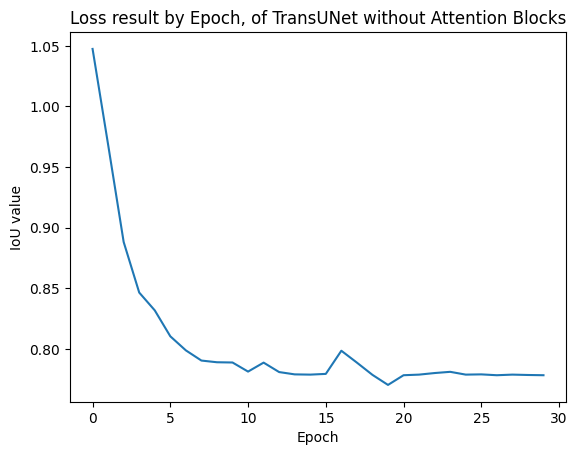

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_res)
plt.title('Loss result by Epoch, of TransUNet without Attention Blocks')
plt.xlabel('Epoch')
plt.ylabel('IoU value')
plt.show()

## Validation

Load the saved models

In [13]:
model1 = TransUNet().to(device)

# Load the saved state dictionary
model1.load_state_dict(torch.load('/content/drive/My Drive/EC523Project/transunet_model1_state.pth'))

# Don't forget to set the model to eval mode if you're doing inference
model1.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batc

TransUNet(
  (backbone): ResNetBackbone(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)

In [ ]:
import pickle
# Specify the file path
file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset_val.pkl'
# Open the file in read-binary mode and load the dataset
with open(file_path, 'rb') as file:
    val_dataset = pickle.load(file)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True)

KeyboardInterrupt: ignored

tensor([[[[0.4512, 0.4512, 0.4527,  ..., 0.4547, 0.4562, 0.4562],
          [0.4512, 0.4512, 0.4527,  ..., 0.4547, 0.4562, 0.4562],
          [0.4541, 0.4541, 0.4551,  ..., 0.4538, 0.4546, 0.4546],
          ...,
          [0.4664, 0.4664, 0.4653,  ..., 0.4509, 0.4483, 0.4483],
          [0.4670, 0.4670, 0.4654,  ..., 0.4488, 0.4455, 0.4455],
          [0.4670, 0.4670, 0.4654,  ..., 0.4488, 0.4455, 0.4455]]]],
       device='cuda:0')
Number of True values: 0
Number of False values: 122500


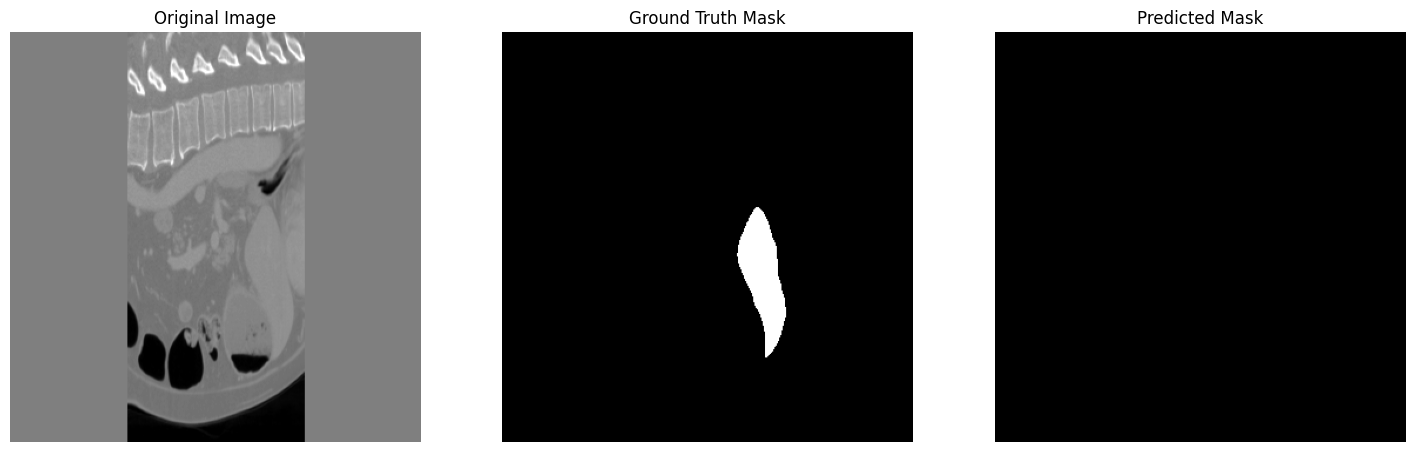

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_segmentation(model, data_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device).float()
            masks = batch['mask'].to(device).float()

            # Get the model predictions
            predictions = model(images)

            # Convert predictions to binary masks
            print(torch.sigmoid(predictions))
            predicted_masks = torch.sigmoid(predictions) > 0.5

            num_true = torch.sum(predicted_masks).item()  # Counts the number of True values
            num_false = predicted_masks.numel() - num_true  # Total number of elements minus the number of True values

            print("Number of True values:", num_true)
            print("Number of False values:", num_false)


            # Move data back to CPU and remove extra dimensions
            images = images.cpu().squeeze().numpy()
            true_masks = masks.cpu().squeeze().numpy()
            predicted_masks = predicted_masks.cpu().squeeze().numpy()

            # Visualization
            plt.figure(figsize=(18, 6))

            plt.subplot(1, 3, 1)
            plt.imshow(images, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(true_masks, cmap='gray')
            plt.title('Ground Truth Mask')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(predicted_masks, cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.show()
            break  # Visualize for one batch only

visualize_segmentation(model1, train_loader, device)

In [ ]:
model1.eval()
total_loss = 0.0
total_iou = 0.0
num_samples = 0
criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for batch in train_loader:
        images = batch['image'].to(device).float()
        masks = batch['mask'].to(device).float()

        out = model1(images)
        loss = criterion(out, masks)

        iou_val = iou(out, masks)
        total_iou += iou_val * images.size(0)
        total_loss += loss.item() * images.size(0)
        num_samples += images.size(0)

average_loss = total_loss / num_samples
average_iou = total_iou / num_samples
print('Validation Loss: {:.4f}, Validation IoU: {:.4f}'.format(average_loss, average_iou))

KeyboardInterrupt: ignored